# FDU PRML 2023 Fall Assignment 2.1

Name: <田沐钊> 
Student ID: <21307140069>

<font color='red'>**Deadline: 2023-11-20 23:59**</font>
<font color='red'>**Overall score weight: 70/100**</font>

In this semester, we are going to complete 3 assignments, each may contain **2-3 parts**. This is the second (and the last) part of the second assignment, in which we will get to implement our own Pytorch-like library.

## 1. FDUNN: your toy torch-like deep learning library (40 points)

In this assignment, you will fist implement your own torch-like deep learning library with `numpy`, named `fdunn`.

PyTorch: [Link](https://pytorch.org/)

In [1]:
# setup code, auto reload your .py file
%load_ext autoreload
%autoreload 2

In [2]:
# numpy
import numpy as np
np.random.seed(233)

In [3]:
# matplotlib
%matplotlib inline
from matplotlib import pyplot as plt

You have to impletement several standard deep neural network modules in the `./fdunn` folder:
1.   linear/conv/pooling
2.   activation
3.   loss
4.   optim
5.   trainer

We have written most of the code for you already, and you only need to fill in the most essential parts. We have also prepared several test cases for you to check if your code works correctly.

Furthermore, you can also test the accuracy of your code by comparing its output with the output of sk-learn.

In [4]:
from fdunn import *


## 2. Deep Learning with Image/Text Data (20 points)

Use your fdunn lib to perform image classification on MNIST or CIFAR10 dataset.

- MNIST: http://yann.lecun.com/exdb/mnist/
- CIFAR10: https://www.cs.toronto.edu/~kriz/cifar.html

一些说明：  
这里由于不需要实现metrics，故对trainer进行了一定的修改。   
此外，为了方便代码的实现，在一定程度上简化了某些模块的信息输入（比如默认卷积的步长和padding为1，并将卷积和池化的步长设为常数而不是一个元组）。  
此外，在最开始的实现中，我的卷积运算和池化运算均使用了至少四重循环，导致程序的运行速度极慢，运行一个epoch需要23小时40分钟，故尝试优化。在第二版算法中，大范围使用了numpy的广播算法进行优化，使循环层数降到了两层，运行一个epoch需要40分钟，虽然已经有了相当大的提升，但明显还是太慢。此后又尝试使用了python自带的concurrent包来实现并行操作，但效果并不好。故在一系列的资料查询后，尝试使用快速卷积算法来对算法进行优化，即将卷积核和存储格式为NCHW的原矩阵均拉成列并拼接为新的二维矩阵，便可将卷积运算转化为矩阵乘法运算。由于numpy内置的矩阵乘法运算有许多底层上的算法优化和并行处理，故计算速度比常规的for循环以及传统的卷积运算要快许多。（原理如下图所示）  
![](原理.png)  

  
此外，为了实现原矩阵的转换，这里使用了im2col方法。卷积层同理，也使用了类似的优化。而这些转换函数则统一存在了modules的utils.py文件中。  
而现在的程序可以在不到一分钟的时间内跑完一个epoch，且准确率可以相当快速地提高。（具体的运行时间在下面的进度条旁边有显示）

In [5]:
import torch
import torchvision
import torchvision.transforms as transforms

# Download and preprocess the MNIST dataset
transform = transforms.Compose([transforms.ToTensor()])

train_dataset = torchvision.datasets.MNIST(root='./mnist_data', train=True, download=True, transform=transform)

test_dataset = torchvision.datasets.MNIST(root='./mnist_data', train=False, transform=transform, download=True)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=16, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=16, shuffle=False)



In [6]:
from fdunn.modules.base import Module
from fdunn.modules.activation import Sigmoid
from fdunn.modules.conv import Conv2d
from fdunn.modules.linear import Linear
from fdunn.modules.pooling import MaxPool2d

# 构建CNN模型
class CNN(Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.layers = [
            Conv2d(1, 4, (3, 3)),
            Sigmoid(),
            MaxPool2d((2, 2), 2),
            Conv2d(4, 8, (3, 3)),
            Sigmoid(),
            MaxPool2d((2, 2), 2),
            Linear(8 * 7 * 7, 100),
            Sigmoid(),
            Linear(100, 10)
        ]

    def forward(self, x):
        x = self.layers[2](self.layers[1](self.layers[0](x)))
        x = self.layers[5](self.layers[4](self.layers[3](x)))
        x = x.reshape(x.shape[0], -1)
        x = self.layers[7](self.layers[6](x))
        x = self.layers[8](x)
        return x
    
    def backward(self, output_grad):
        input_grad = self.layers[8].backward(output_grad)
        input_grad = self.layers[7].backward(input_grad)
        input_grad = self.layers[6].backward(input_grad)
        input_grad = self.layers[5].backward(input_grad.reshape(input_grad.shape[0], 8, 7, 7))
        input_grad = self.layers[4].backward(input_grad)
        input_grad = self.layers[3].backward(input_grad) 
        input_grad = self.layers[2].backward(input_grad)
        input_grad = self.layers[1].backward(input_grad)
        input_grad = self.layers[0].backward(input_grad)


epoch: 0


100%|██████████| 3750/3750 [00:39<00:00, 95.48it/s] 


loss:  0.24695351769662088
accuracy:  0.9258
epoch: 1


100%|██████████| 3750/3750 [00:33<00:00, 112.75it/s]


loss:  0.13008267439511392
accuracy:  0.9606
epoch: 2


100%|██████████| 3750/3750 [00:33<00:00, 112.41it/s]


loss:  0.10290417333985527
accuracy:  0.9666
epoch: 3


100%|██████████| 3750/3750 [00:33<00:00, 110.66it/s]


loss:  0.07426428649319042
accuracy:  0.9765
epoch: 4


100%|██████████| 3750/3750 [00:32<00:00, 114.25it/s]


loss:  0.06908338196077692
accuracy:  0.9773
epoch: 5


100%|██████████| 3750/3750 [00:32<00:00, 114.73it/s]


loss:  0.06380196041900889
accuracy:  0.9784
epoch: 6


100%|██████████| 3750/3750 [00:35<00:00, 106.84it/s]


loss:  0.06197271463015396
accuracy:  0.98
epoch: 7


100%|██████████| 3750/3750 [00:33<00:00, 112.51it/s]


loss:  0.05270952772320125
accuracy:  0.9822
epoch: 8


100%|██████████| 3750/3750 [00:32<00:00, 114.84it/s]


loss:  0.05174629718487412
accuracy:  0.9826
epoch: 9


100%|██████████| 3750/3750 [00:33<00:00, 112.80it/s]


loss:  0.05661924575113812
accuracy:  0.9808


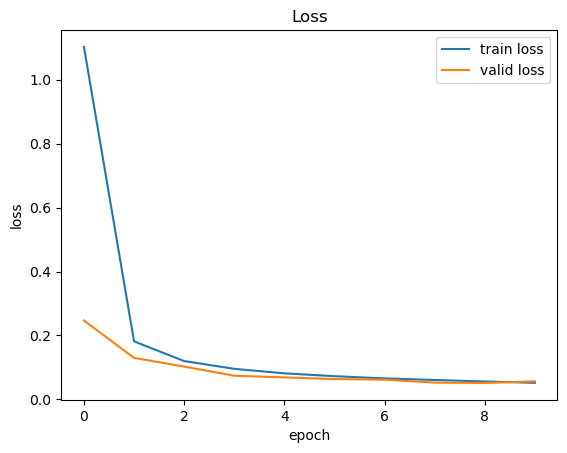

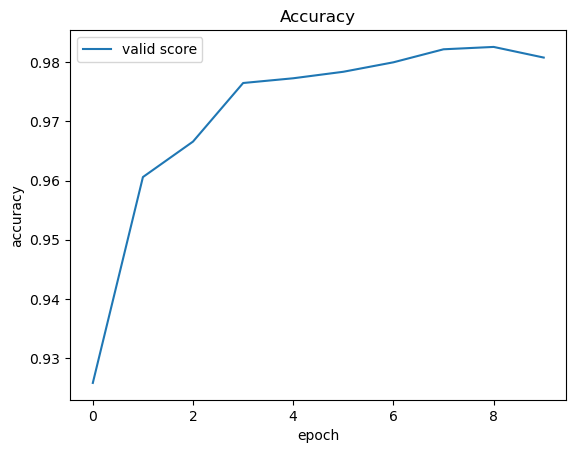

In [7]:

from fdunn.modules.loss import CrossEntropyLoss
from fdunn.optim.sgd import SGD
from fdunn.trainer import Trainer

# 开始训练
CNN_net = CNN()
loss_fn = CrossEntropyLoss(CNN_net, 10)
learning_rate = 0.01
optimizer = SGD(CNN_net, lr=learning_rate)

epoch = 10

trainer = Trainer(CNN_net, optimizer, loss_fn, epoch)
trainer.train(train_loader, test_loader)

train_loss = trainer.train_loss
valid_loss = trainer.valid_loss
valid_scores = trainer.valid_scores

x = range(epoch)
plt.plot(x, train_loss, label='train loss')
plt.plot(x, valid_loss, label='valid loss')
plt.title('Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

plt.plot(x, valid_scores, label='valid score')
plt.title('Accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.show()


## 3. Advanced Topics (10 points)

You can try to implement some advanced topics in deep learning with our fdunn in this section.

We will divide the topics into two categories: modules and optimization, with 5 points for each category.

### 3.1 Modules

Pick one of the following (trending or classic) topics and implement it with fdunn. Try to implement it and design a toy test case to show that your implementation is correct (say we can compare the forward and backward results with the results of corresponding Pytorch modules with the same weight).

- Batch/Layer/Group Normalization (just one of them is fine)
- A ReLU/GeLU/SiLU activation function (just one of them is fine)
- A Gated Linear Unit (GLU)
- An RNN cell
- Or any other modules you are interested in


### 3.2 Optimization

Pick one of the following optimization methods and implement it with fdunn.

- SGD with L2 regularization. (Try to repeat your experiment in Assignment 1.1 to see the same 'underregularization' to 'overregularization' phenomenon)
- Adam (Does it converge faster than SGD in the last section?)
- Or any other optimization methods you are interested in (I am far from an expert in optimization, so maybe you can teach me something new here. Say a second order method?)


If you are not sure about what to do, We suggest you to implement the ReLU activation function and SGD with L2 regularization. They are foundamental and (relatively) easy to implement.

Different methods do not vary in scores. So do not chase fancy methods unless you are quite interested in them.

There are many ways to prove your implementation is correct, as long as they are convincing.

epoch: 0


100%|██████████| 3750/3750 [00:33<00:00, 112.57it/s]


loss:  0.2578845566216065
accuracy:  0.9191
epoch: 1


100%|██████████| 3750/3750 [00:32<00:00, 113.83it/s]


loss:  0.12784965232581097
accuracy:  0.9595
epoch: 2


100%|██████████| 3750/3750 [00:32<00:00, 115.05it/s]


loss:  0.08866193716419213
accuracy:  0.9711
epoch: 3


100%|██████████| 3750/3750 [00:33<00:00, 110.74it/s]


loss:  0.07424874327162204
accuracy:  0.9765
epoch: 4


100%|██████████| 3750/3750 [00:32<00:00, 114.71it/s]


loss:  0.07153256186417867
accuracy:  0.9765
epoch: 5


100%|██████████| 3750/3750 [00:32<00:00, 116.10it/s]


loss:  0.05875646994408145
accuracy:  0.9784
epoch: 6


100%|██████████| 3750/3750 [00:32<00:00, 115.17it/s]


loss:  0.054419888360706235
accuracy:  0.982
epoch: 7


100%|██████████| 3750/3750 [00:32<00:00, 114.36it/s]


loss:  0.056248828674050094
accuracy:  0.9808
epoch: 8


100%|██████████| 3750/3750 [00:33<00:00, 113.27it/s]


loss:  0.050435655800358435
accuracy:  0.9824
epoch: 9


100%|██████████| 3750/3750 [00:32<00:00, 114.63it/s]


loss:  0.05006883985130728
accuracy:  0.9832


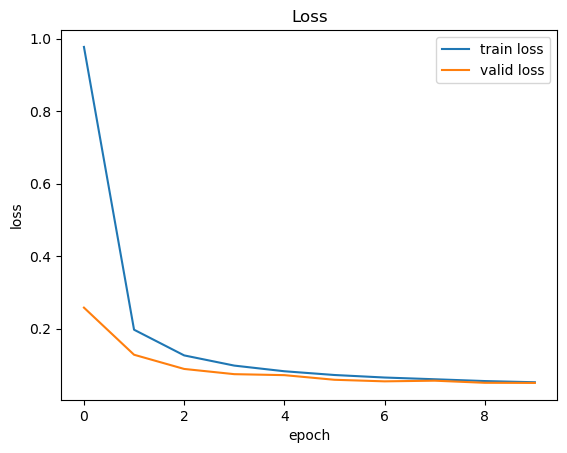

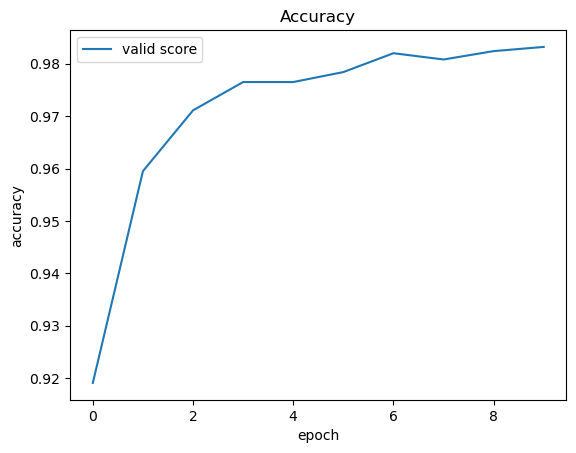

In [8]:
from fdunn.modules.activation import ReLU

# 构建CNN模型
class ReLU_CNN(Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.layers = [
            Conv2d(1, 4, (3, 3)),
            ReLU(),
            MaxPool2d((2, 2), 2),
            Conv2d(4, 8, (3, 3)),
            ReLU(),
            MaxPool2d((2, 2), 2),
            Linear(8 * 7 * 7, 100),
            ReLU(),
            Linear(100, 10)
        ]

    def forward(self, x):
        x = self.layers[2](self.layers[1](self.layers[0](x)))
        x = self.layers[5](self.layers[4](self.layers[3](x)))
        x = x.reshape(x.shape[0], -1)
        x = self.layers[7](self.layers[6](x))
        x = self.layers[8](x)
        return x
    
    def backward(self, output_grad):
        input_grad = self.layers[8].backward(output_grad)
        input_grad = self.layers[7].backward(input_grad)
        input_grad = self.layers[6].backward(input_grad)
        input_grad = self.layers[5].backward(input_grad.reshape(input_grad.shape[0], 8, 7, 7))
        input_grad = self.layers[4].backward(input_grad)
        input_grad = self.layers[3].backward(input_grad) 
        input_grad = self.layers[2].backward(input_grad)
        input_grad = self.layers[1].backward(input_grad)
        input_grad = self.layers[0].backward(input_grad)


# 开始训练
CNN_net = CNN()
loss_fn = CrossEntropyLoss(CNN_net, 10)
learning_rate = 0.01
optimizer = SGD(CNN_net, lr=learning_rate)

epoch = 10

ReLU_trainer = Trainer(CNN_net, optimizer, loss_fn, epoch)
ReLU_trainer.train(train_loader, test_loader)

train_loss = ReLU_trainer.train_loss
valid_loss = ReLU_trainer.valid_loss
valid_scores = ReLU_trainer.valid_scores

x = range(epoch)
plt.plot(x, train_loss, label='train loss')
plt.plot(x, valid_loss, label='valid loss')
plt.title('Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

plt.plot(x, valid_scores, label='valid score')
plt.title('Accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.show()

epoch: 0


100%|██████████| 3750/3750 [00:33<00:00, 111.89it/s]


loss:  0.07070189314945556
accuracy:  0.9785
epoch: 1


100%|██████████| 3750/3750 [00:33<00:00, 111.97it/s]


loss:  0.05960394818615962
accuracy:  0.9817
epoch: 2


100%|██████████| 3750/3750 [00:33<00:00, 111.59it/s]


loss:  0.052537222330124006
accuracy:  0.9842
epoch: 3


100%|██████████| 3750/3750 [00:34<00:00, 109.90it/s]


loss:  0.05299581118157089
accuracy:  0.984
epoch: 4


100%|██████████| 3750/3750 [00:34<00:00, 110.07it/s]


loss:  0.06465332657147044
accuracy:  0.9824
epoch: 5


100%|██████████| 3750/3750 [00:34<00:00, 110.14it/s]


loss:  0.06836706369732505
accuracy:  0.9816
epoch: 6


100%|██████████| 3750/3750 [00:34<00:00, 108.06it/s]


loss:  0.0694157834037603
accuracy:  0.982
epoch: 7


100%|██████████| 3750/3750 [00:33<00:00, 111.39it/s]


loss:  0.06894528987812423
accuracy:  0.9819
epoch: 8


100%|██████████| 3750/3750 [00:33<00:00, 111.16it/s]


loss:  0.07351837762993962
accuracy:  0.9815
epoch: 9


100%|██████████| 3750/3750 [00:33<00:00, 111.69it/s]


loss:  0.0722322738966531
accuracy:  0.9832


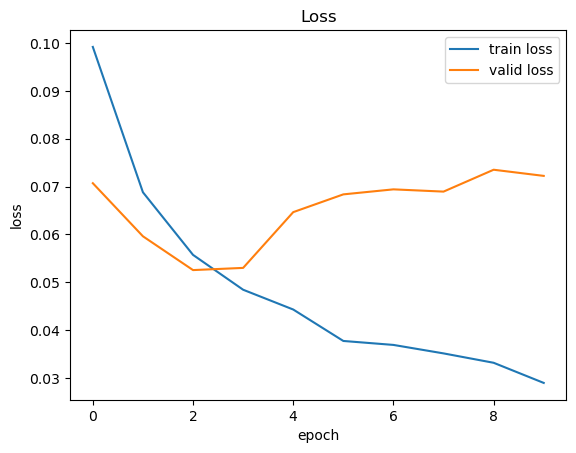

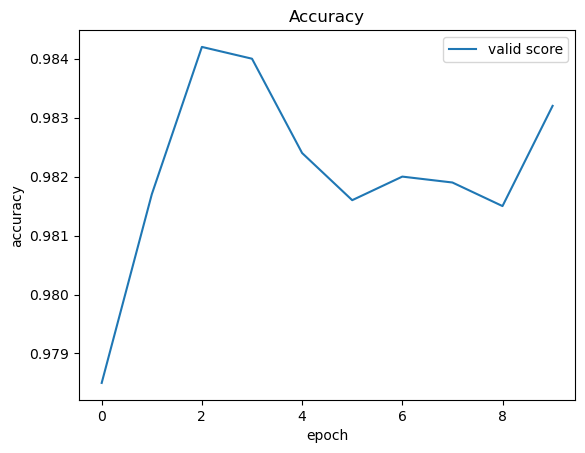

In [9]:
from fdunn.optim.Adam import Adam

optimizer = Adam(CNN_net)

epoch = 10

L2_trainer = Trainer(CNN_net, optimizer, loss_fn, epoch)
L2_trainer.train(train_loader, test_loader)

train_loss = L2_trainer.train_loss
valid_loss = L2_trainer.valid_loss
valid_scores = L2_trainer.valid_scores

x = range(epoch)
plt.plot(x, train_loss, label='train loss')
plt.plot(x, valid_loss, label='valid loss')
plt.title('Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

plt.plot(x, valid_scores, label='valid score')
plt.title('Accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.show()